In [1]:
import os
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


### input_shape is set to the desired input shape of the images.
### dataset_dir is the directory path to the dataset.
### batch_size determines the number of samples per gradient update during training.

In [2]:
input_shape = (224, 224, 3)
dataset_dir = r'E:\2023 OBU-CDUT\2023 Semester 1\crc_skin_data'
batch_size = 4


In [3]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 20% of the data will be used for validation

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training')  # Use the training subset of the data

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')  # Use the validation subset of the data

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary')

# Rest of the code remains the same...


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### inception_block is a function that defines an Inception-like block with factorization.
### It takes inputs and filters as input. filters is a list representing the number of output channels for each convolution operation in the block.
### The block consists of multiple branches with different convolution operations, including 1x1, 3x3, and 5x5 convolutions.
### The outputs of all branches are concatenated using Concatenate.

#### Conv2D is a convolutional layer in Keras that performs a 2D convolution operation.
#### filters[0] refers to the number of filters (output channels) in this convolutional layer. It is the first element of the filters list.
#### (1, 1) specifies the size of the convolutional kernel, which is a 1x1 kernel in this case.

#### Concatenate is a layer in Keras that concatenates multiple tensors along a specified axis.
#### axis=-1 specifies that the concatenation should happen along the last axis of the tensors.
#### [branch1, branch2, branch3, branch4] is a list containing the tensors branch1, branch2, branch3, and branch4 that will be concatenated.

In [4]:
def inception_block(inputs, filters):
    branch1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(inputs)
    branch1 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(branch1)

    branch2 = Conv2D(filters[2], (1, 1), padding='same', activation='relu')(inputs)
    branch2 = Conv2D(filters[3], (5, 5), padding='same', activation='relu')(branch2)

    branch3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    branch3 = Conv2D(filters[4], (1, 1), padding='same', activation='relu')(branch3)

    branch4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(inputs)

    output = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return output


### InceptionModel is a function that defines the Inception-like model using the previously defined inception_block.
### It takes input_shape and num_classes as input.
### The model starts with a convolution layer followed by two inception blocks.
### After the inception blocks, global average pooling is applied, followed by a dense layer.
### Finally, the output layer with the specified number of classes and activation function is added.
### The model is returned as a Model instance.

In [5]:
def InceptionModel(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution layer
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    
    # Inception Blocks
    x = inception_block(x, [16, 32, 8, 16, 8, 16])
    x = inception_block(x, [32, 64, 16, 32, 16, 32])
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    x = inception_block(x, [64, 128, 32, 64, 32, 64])
    x = inception_block(x, [128, 256, 64, 128, 64, 128])
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)

    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


### num_classes is set to 1 since the problem is binary classification.
### The model is created using InceptionModel with the specified input shape and number of classes.
### The model is compiled with the binary cross-entropy loss function, the Adam optimizer, and accuracy as the evaluation metric.

In [6]:
num_classes = 1
model = InceptionModel(input_shape, num_classes)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [7]:
history = model.fit(train_generator, epochs=2, validation_data=validation_generator, verbose=1)


Epoch 1/2
100/100 [==============================] - 62s 622ms/step - loss: 0.6974 - accuracy: 0.4900 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/2
100/100 [==============================] - 60s 600ms/step - loss: 0.7445 - accuracy: 0.5150 - val_loss: 0.6916 - val_accuracy: 0.5100


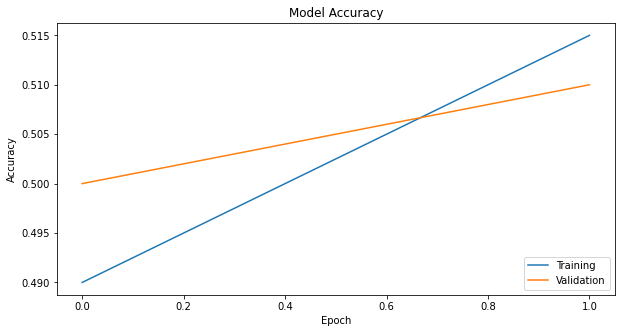

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


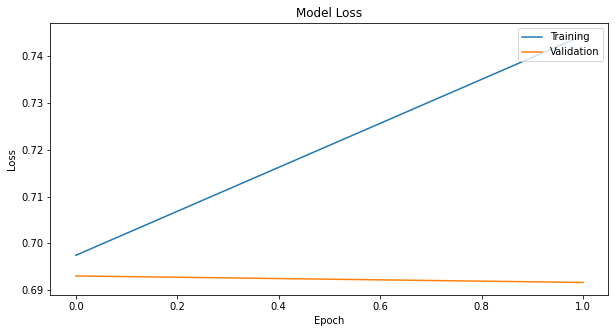

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

25/25 [==============================] - 4s 172ms/step - loss: 0.6885 - accuracy: 0.5600
Test Loss: 0.6885324120521545
Test Accuracy: 0.5600000023841858


In [11]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [12]:
# you will need to install numba using "pip install numba"
from numba import cuda

cuda.select_device(0)
cuda.close()